In [1]:
import numpy as np
import tvm
from tvm import relax, topi
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [2]:
@tvm.script.ir_module
class MyModule:
    @R.function
    def main(x: R.Tensor((3, 4), "float32"), y: R.Tensor((3, 4), "float32")):
        with R.dataflow():
            lv0 = relax.op.multiply(x, y)
            gv0 = relax.op.add(lv0, y)
            R.output(gv0)
        return gv0

In [3]:
relax_func = MyModule["main"]

In [7]:
func_body = relax_func.body
type(func_body)

x: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
with R.dataflow():
    lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
    gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)
    R.output(gv0)
gv0

In [8]:
func_body.blocks

[x: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
with R.dataflow():
    lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y)
    gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)
    R.output(gv0)]

In [9]:
dataflow_block = func_body.blocks[0]

In [10]:
dataflow_block.bindings

[x: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
lv0: R.Tensor((3, 4), dtype="float32") = R.multiply(x, y), lv0: R.Tensor((3, 4), dtype="float32")
y: R.Tensor((3, 4), dtype="float32")
gv0: R.Tensor((3, 4), dtype="float32") = R.add(lv0, y)]

In [11]:
binding = dataflow_block.bindings[0]

In [13]:
binding.var, binding.value

(lv0, R.multiply(x, y))

In [20]:
@relax.expr_functor.mutator
class EwiseFMARewriter(relax.PyExprMutator):
    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)
        add_op = tvm.ir.Op.get("relax.add")
        multiply_op = tvm.ir.Op.get("relax.multiply")
        ewise_fma_op = tvm.ir.Op.get("relax.ewise_fma")

        if call.op != add_op:
            return call

        value = self.lookup_binding(call.args[0])
        if not isinstance(value, relax.Call) or value.op != multiply_op:
            return call

        fma_call = relax.Call(
            ewise_fma_op, [value.args[0], value.args[1], call.args[1]], None, None
        )
        return fma_call


updated_fn = EwiseFMARewriter().visit_expr(MyModule["main"])
updated_fn.show()

In [21]:
relax.analysis.remove_all_unused(updated_fn).show()

In [22]:
# Hide outputs
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2024-11-29 00:51:57--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Connecting to 127.0.0.1:7890... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2024-11-29 00:51:59--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Connecting to 127.0.0.1:7890... connected.
Proxy request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl.1’

fasionmnist_mlp_par 100%[===================>] 397.85K   181KB/s    in 2.2s    

2024-11-29 00:52:03 (181 KB/s) - ‘fasionmnist_mlp_params.pkl.1’ saved [407396/407396]



In [23]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

In [24]:
def create_model():
    bb = relax.BlockBuilder()
    x = relax.Var("x", relax.TensorStructInfo((1, 784), "float32"))
    w0 = relax.const(mlp_params["w0"], "float32")
    b0 = relax.const(mlp_params["b0"], "float32")
    w1 = relax.const(mlp_params["w1"], "float32")
    b1 = relax.const(mlp_params["b1"], "float32")
    with bb.function("main", [x]):
        with bb.dataflow():
            lv0 = bb.emit(relax.op.matmul(x, relax.op.permute_dims(w0)))
            lv1 = bb.emit(relax.op.add(lv0, b0))
            lv2 = bb.emit(relax.op.nn.relu(lv1))
            lv3 = bb.emit(relax.op.matmul(lv2, relax.op.permute_dims(w1)))
            lv4 = bb.emit(relax.op.add(lv3, b1))
            gv = bb.emit_output(lv4)
        bb.emit_func_output(gv)

    return bb.get()

MLPModel = create_model()
MLPModel.show()

In [25]:
@relax.expr_functor.mutator
class MatmulAddFusor(relax.PyExprMutator):
    def __init__(self, mod: IRModule) -> None:
        super().__init__()
        self.mod_ = mod
        # cache pre-defined ops
        self.add_op = tvm.ir.Op.get("relax.add")
        self.matmul_op = tvm.ir.Op.get("relax.matmul")
        self.counter = 0

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            # avoid already fused primitive functions
            if func.attrs is not None and "Primitive" in func.attrs.keys() and func.attrs["Primitive"] != 0:
                continue
            updated_func = self.visit_expr(func)
            updated_func = relax.analysis.remove_all_unused(updated_func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()

    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        def match_call(node, op):
            if not isinstance(node, relax.Call):
                return False
            return node.op == op

        # pattern match matmul => add
        if not match_call(call, self.add_op):
            return call

        value = self.lookup_binding(call.args[0])
        if value is None:
            return call

        if not match_call(value, self.matmul_op):
            return call

        x = value.args[0]
        w = value.args[1]
        b = call.args[1]

        # construct a new fused primitive function
        param_x = relax.Var("x" ,relax.TensorStructInfo(x.struct_info.shape, x.struct_info.dtype))
        param_w = relax.Var("w" ,relax.TensorStructInfo(w.struct_info.shape, w.struct_info.dtype))
        param_b = relax.Var("b" ,relax.TensorStructInfo(b.struct_info.shape, b.struct_info.dtype))

        bb = relax.BlockBuilder()

        fn_name = "fused_matmul_add%d" % (self.counter)
        self.counter += 1
        with bb.function(fn_name, [param_x, param_w, param_b]):
            with bb.dataflow():
                lv0 = bb.emit(relax.op.matmul(param_x, param_w))
                gv = bb.emit_output(relax.op.add(lv0, param_b))
            bb.emit_func_output(gv)

        # Add Primitive attribute to the fused funtions
        fused_fn = bb.get()[fn_name].with_attr("Primitive", 1)
        global_var = self.builder_.add_func(fused_fn, fn_name)

        # construct call into the fused function
        return relax.Call(global_var, [x, w, b], None, None)

@tvm.ir.transform.module_pass(opt_level=2, name="MatmulAddFuse")
class FuseDenseAddPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return MatmulAddFusor(mod).transform()


MLPFused = FuseDenseAddPass()(MLPModel)
MLPFused.show()

In [26]:
@relax.expr_functor.mutator
class LowerToTensorIR(relax.PyExprMutator):
    def __init__(self, mod: IRModule, op_map) -> None:
        super().__init__()
        self.mod_ = mod
        self.op_map = {
            tvm.ir.Op.get(k): v for k, v in op_map.items()
        }


    def visit_call_(self, call):
        call = self.visit_expr_post_order(call)

        if call.op in self.op_map:
            return self.op_map[call.op](self.builder_, call)
        return call

    def transform(self) -> IRModule:
        for global_var, func in self.mod_.functions.items():
            if not isinstance(func, relax.Function):
                continue
            updated_func = self.visit_expr(func)
            self.builder_.update_func(global_var, updated_func)

        return self.builder_.get()


def map_matmul(bb, call):
    x, w = call.args
    return bb.call_te(topi.nn.matmul, x, w)

def map_add(bb, call):
    a, b = call.args
    return bb.call_te(topi.add, a, b)

def map_relu(bb, call):
    return bb.call_te(topi.nn.relu, call.args[0])

def map_transpose(bb, call):
    return bb.call_te(topi.transpose, call.args[0], )

op_map = {
  "relax.matmul": map_matmul,
  "relax.add": map_add,
  "relax.nn.relu": map_relu,
  "relax.permute_dims": map_transpose
}

@tvm.ir.transform.module_pass(opt_level=0, name="LowerToTensorIR")
class LowerToTensorIRPass:
    """The wrapper for the LowerTensorIR pass."""
    def transform_module(self, mod, ctx):
        return LowerToTensorIR(mod, op_map).transform()


MLPModelTIR = LowerToTensorIRPass()(MLPFused)
MLPModelTIR.show()

In [27]:
MLPModelFinal = relax.transform.FuseTIR()(MLPModelTIR)
MLPModelFinal.show()

In [28]:
# Hide outputs
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

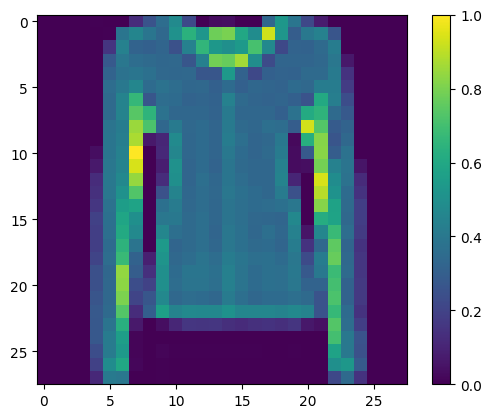

Class: Pullover


In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [30]:
ex = relax.build(MLPModelFinal, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Pullover
